In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, brier_score_loss, confusion_matrix

DATA_PATH = "combined_cleaned.csv"

BATCH_SIZE = 512
LR = 1e-3
EPOCHS = 100
PATIENCE = 10

# CNN hyperparameters
HORIZON = 5          # future window for realized volatility
LOOKBACK = 10        # past days in temporal window
CHANNELS_1 = 64
CHANNELS_2 = 64
KERNEL_SIZE = 5
HIDDEN_DIM = 64
DROPOUT_CONV = 0.3
DROPOUT_DENSE = 0.4
HIGH_VOL_Q = 0.5

# Base features
BASE_FEATURES = ["log_return","lag1","lag3","lag5","MA5","MA20","vol_5","Volume","rel_vol","regime_high_vol"]

# Features inputted into the CNN
CANDIDATE_FEATURES = ["log_return","lag1","lag3","lag5","MA5","MA20","vol_5","Volume","rel_vol","regime_high_vol",# Base features
    "MA_diff","return_over_vol","volume_spike","log_return_z_cs","MA5_z_cs","MA20_z_cs","vol_5_z_cs","Volume_z_cs","rel_vol_z_cs","log_return_rank_cs","vol_5_rank_cs","Volume_rank_cs"] # Engineered features

# Candidate probability thresholds for converting CNN outputs into binary labels (0/1)
THRESHOLDS = [0.40, 0.45, 0.50, 0.55, 0.60]

# Parse dates, sort by (Ticker, Date), and drop invalid / duplicate rows
def load_and_basic_clean(path):
    df = pd.read_csv(path)
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
    df = df.dropna(subset=["Date"]).copy()
    df = df.sort_values(["Ticker", "Date"])
    df = df.drop_duplicates(subset=["Ticker", "Date"])
    return df

# Compute log_return based on that ticker’s Close series if not already done so
def ensure_log_return(df):
    df = df.copy()
    if "log_return" not in df.columns:
        df["log_return"] = (
            np.log(df["Close"]) - np.log(df.groupby("Ticker")["Close"].shift(1))
        )
    return df

# Add market regime classification based on the median of the market volatility
def add_market_regime(df, vol_window=20, min_periods=10):
    df = df.copy()
    mkt_ret = (
        df.groupby("Date")["log_return"]
          .mean()
          .sort_index()
    )
    mkt_vol = mkt_ret.rolling(window=vol_window, min_periods=min_periods).std()
    vol_median = mkt_vol.median()
    df["market_vol"] = df["Date"].map(mkt_vol)
    df["regime_high_vol"] = (df["market_vol"] > vol_median).astype(int)
    return df

# Compute realized volatility for the next 5 days
def add_realized_vol_5(df, horizon=5):
    """
    realized_vol_5(t) = sqrt( (r_{t+1}^2 + ... + r_{t+horizon}^2) / horizon )
    where r_t = log_return.
    """
    df = df.copy()
    df["realized_vol_5"] = np.nan
    for ticker, g in df.groupby("Ticker"):
        idx = g.index
        r = g["log_return"]
        r_sq = r ** 2
        acc = None
        for i in range(1, horizon + 1):
            shifted = r_sq.shift(-i)
            acc = shifted if acc is None else acc + shifted
        rv5 = np.sqrt(acc / horizon)
        df.loc[idx, "realized_vol_5"] = rv5
    return df

# Add engineered features (MA_diff, return_over_vol, and volume_spike) that help the CNN see trend, risk-adjusted moves, and unusual volume.
def add_interaction_features(df):
    df = df.copy()

    # MA_diff = MA5 - MA20
    if "MA5" in df.columns and "MA20" in df.columns:
        df["MA_diff"] = df["MA5"] - df["MA20"]

    # return_over_vol = log_return / (vol_5 + eps)
    if "log_return" in df.columns and "vol_5" in df.columns:
        eps = 1e-6
        df["return_over_vol"] = df["log_return"] / (df["vol_5"].replace(0, np.nan) + eps)

    # volume_spike = Volume today / 20-day rolling mean Volume (per ticker, window ending today)
    if "Volume" in df.columns:
        df["volume_spike"] = np.nan
        for ticker, g in df.groupby("Ticker"):
            idx = g.index
            vol = g["Volume"]
            vol_ma20 = vol.rolling(window=20, min_periods=5).mean()  # past 20 days
            df.loc[idx, "volume_spike"] = vol / (vol_ma20.replace(0, np.nan))

    return df

# Add cross-sectional z-scores and ranks to help the CNN see how each feature compares to others on the same day.
def add_cross_sectional_features(df):
    df = df.copy()

    cs_cols_for_z = ["log_return","MA5","MA20","vol_5","Volume","rel_vol"]

    # Add z-scores for each feature
    for col in cs_cols_for_z:
        if col not in df.columns:
            continue
        group = df.groupby("Date")[col]
        mean = group.transform("mean")
        std = group.transform("std").replace(0, np.nan)
        z_name = f"{col}_z_cs"
        df[z_name] = (df[col] - mean) / std
        df[z_name] = df[z_name].fillna(0.0)  # default to 0 if no std

    # Add rank-based features (0-1, within each date)
    rank_cols = ["log_return", "vol_5", "Volume"]
    for col in rank_cols:
        if col not in df.columns:
            continue
        r_name = f"{col}_rank_cs"
        df[r_name] = (
            df.groupby("Date")[col]
              .rank(pct=True)
        )

    return df

# Get the features that are actually in the dataframe
def get_feature_columns(df):
    feature_cols = [c for c in CANDIDATE_FEATURES if c in df.columns]
    if not feature_cols:
        raise ValueError("No candidate features found in dataframe.")
    df = df.dropna(subset=feature_cols).copy()
    feature_cols = [c for c in feature_cols if c in df.columns]
    return df, feature_cols

# Define the folds for the cross-validation
def define_folds():
    folds = [
        {
            "name": "fold1",
            "train_start": "2009-01-01",
            "train_end":   "2013-12-31",
            "val_start":   "2014-01-01",
            "val_end":     "2014-12-31",
            "test_start":  "2015-01-01",
            "test_end":    "2015-12-31",
        },
        {
            "name": "fold2",
            "train_start": "2009-01-01",
            "train_end":   "2014-12-31",
            "val_start":   "2015-01-01",
            "val_end":     "2015-12-31",
            "test_start":  "2016-01-01",
            "test_end":    "2016-12-31",
        },
        {
            "name": "fold3",
            "train_start": "2009-01-01",
            "train_end":   "2015-12-31",
            "val_start":   "2016-01-01",
            "val_end":     "2016-12-31",
            "test_start":  "2017-01-01",
            "test_end":    "2017-12-31",
        },
    ]
    for f in folds:
        for k in ["train_start","train_end","val_start","val_end","test_start","test_end"]:
            f[k] = pd.to_datetime(f[k])
    return folds

# Build sequences: X (N, LOOKBACK, d), rv5 (N,), dates (N,) (N is the number of samples, L is the lookback window, d is the number of features)
def build_sequences(df, feature_cols, lookback):
    X_list, rv_list, date_list, ticker_list = [], [], [], []
    for ticker, g in df.groupby("Ticker"):
        g = g.sort_values("Date")
        feats = g[feature_cols].values
        rv5 = g["realized_vol_5"].values
        dates = g["Date"].values
        tickers = g["Ticker"].values

        if len(g) < lookback:
            continue

        for i in range(lookback - 1, len(g)):
            if np.isnan(rv5[i]):
                continue  # need full future 5 days
            X_list.append(feats[i - lookback + 1:i + 1, :])
            rv_list.append(rv5[i])
            date_list.append(dates[i])
            ticker_list.append(tickers[i])

    X = np.array(X_list)          # (N, L, d)
    rv = np.array(rv_list)        # (N,)
    dates = np.array(date_list)   # (N,)
    tickers = np.array(ticker_list)
    return X, rv, dates, tickers


# Build the temporal CNN model
def build_temporal_cnn_single(lookback, n_features):
    inp = tf.keras.Input(shape=(lookback, n_features))
    x = tf.keras.layers.Conv1D(filters=CHANNELS_1, kernel_size=KERNEL_SIZE, activation="relu", padding="same")(inp)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(DROPOUT_CONV)(x)
    x = tf.keras.layers.Conv1D(filters=CHANNELS_2, kernel_size=KERNEL_SIZE, activation="relu", padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(DROPOUT_CONV)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(HIDDEN_DIM, activation="relu")(x)
    x = tf.keras.layers.Dropout(DROPOUT_DENSE)(x)
    out = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss="binary_crossentropy",
    )
    return model

def evaluate_metrics(y_true, y_pred, p_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    try:
        roc_auc = roc_auc_score(y_true, p_pred)
    except ValueError:
        roc_auc = np.nan
    try:
        pr_auc = average_precision_score(y_true, p_pred)
    except ValueError:
        pr_auc = np.nan
    brier = brier_score_loss(y_true, p_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "brier": brier,
        "tn": int(tn),
        "fp": int(fp),
        "fn": int(fn),
        "tp": int(tp),
    }


# Tune the threshold for the binary classification
def tune_threshold(y_val, p_val, thresholds):
    best_tau = 0.5
    best_acc = -1.0
    for tau in thresholds:
        preds = (p_val >= tau).astype(int)
        acc = accuracy_score(y_val, preds)
        if acc > best_acc:
            best_acc = acc
            best_tau = tau
    return best_tau

# Train one fold of the high-vol regime
def train_one_fold_highvol(X, rv5, dates, feature_cols, fold):
    train_mask = (dates >= fold["train_start"]) & (dates <= fold["train_end"])
    val_mask   = (dates >= fold["val_start"])   & (dates <= fold["val_end"])
    test_mask  = (dates >= fold["test_start"])  & (dates <= fold["test_end"])

    X_train, rv_train = X[train_mask], rv5[train_mask]
    X_val,   rv_val   = X[val_mask],   rv5[val_mask]
    X_test,  rv_test  = X[test_mask],  rv5[test_mask]

    if X_train.shape[0] == 0 or X_val.shape[0] == 0 or X_test.shape[0] == 0:
        print(f"[{fold['name']}] skipped (empty split)")
        return None

    # Define high-vol threshold from train realized_vol_5 only (no leakage) (quantile is used to find the threshold for the binary classification)
    thr = np.quantile(rv_train, HIGH_VOL_Q)
    y_train = (rv_train >= thr).astype(int)
    y_val   = (rv_val   >= thr).astype(int)
    y_test  = (rv_test  >= thr).astype(int)

    # Baseline: always predict the majority class as defined on train, and compute its accuracy on the test set.
    pos_ratio_train = y_train.mean()
    majority_label = 1 if pos_ratio_train >= 0.5 else 0
    baseline_acc_test = (y_test == majority_label).mean()

    # Scale features per fold (standardization is used to normalize the features)
    N_train, L, d = X_train.shape
    scaler = StandardScaler()
    X_train_flat = X_train.reshape(N_train * L, d)
    scaler.fit(X_train_flat)

    def transform(X_in):
        N, L, d = X_in.shape
        X_flat = X_in.reshape(N * L, d)
        X_scaled = scaler.transform(X_flat)
        return X_scaled.reshape(N, L, d)

    X_train_scaled = transform(X_train)
    X_val_scaled   = transform(X_val)
    X_test_scaled  = transform(X_test)

    train_ds = tf.data.Dataset.from_tensor_slices(
        (X_train_scaled, y_train.astype("float32"))
    ).shuffle(buffer_size=X_train_scaled.shape[0]).batch(BATCH_SIZE)

    val_ds = tf.data.Dataset.from_tensor_slices(
        (X_val_scaled, y_val.astype("float32"))
    ).batch(BATCH_SIZE)

    model = build_temporal_cnn_single(LOOKBACK, len(feature_cols))

    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)

    print(f"\n===== Training {fold['name']} for 5-day high-vol regime (temporal CNN) =====")
    model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[es], verbose=1)

    val_ds = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val.astype("float32"))).batch(BATCH_SIZE)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test.astype("float32"))).batch(BATCH_SIZE)

    p_val = model.predict(val_ds).ravel()
    p_test = model.predict(test_ds).ravel()

    best_tau = tune_threshold(y_val, p_val, THRESHOLDS)

    y_pred_test = (p_test >= best_tau).astype(int)
    acc_test = accuracy_score(y_test, y_pred_test)

    metrics = evaluate_metrics(y_test, y_pred_test, p_test)

    result = {
        "fold": fold["name"],
        "accuracy": acc_test,
        "baseline_acc": baseline_acc_test,
        "threshold": best_tau,
        "pos_ratio_train": float(pos_ratio_train),
        "n_train": int(X_train.shape[0]),
        "n_test": int(X_test.shape[0]),
    }
    result.update(metrics)
    return result

# Pipeline for CNN
def run_highvol_cnn():
    df = load_and_basic_clean(DATA_PATH)
    df = ensure_log_return(df)
    df = add_market_regime(df)
    df = add_realized_vol_5(df, horizon=HORIZON)

    # Add engineered features
    df = add_interaction_features(df)
    df = add_cross_sectional_features(df)

    # Drop rows without realized_vol_5, which is needed to define the high-vol / low-vol classification label.
    df = df.dropna(subset=["realized_vol_5"]).copy()

    df, feature_cols = get_feature_columns(df)

    X, rv5, dates, tickers = build_sequences(df, feature_cols, LOOKBACK)
    print(f"Sequences built: {X.shape[0]} samples, lookback={LOOKBACK}, features={X.shape[2]}")

    folds = define_folds()
    all_results = []

    for fold in folds:
        res = train_one_fold_highvol(X, rv5, dates, feature_cols, fold)
        if res is not None:
            all_results.append(res)

    results_df = pd.DataFrame(all_results)

    print("\n Per-fold test accuracy for 5-day high-vol regime (CNN)")
    print(results_df[["fold", "accuracy", "baseline_acc", "threshold", "pos_ratio_train", "n_train", "n_test"]])
    print("\n Additional per-fold metrics")
    print(results_df[["fold", "precision", "recall", "f1", "roc_auc", "pr_auc", "brier", "tn", "fp", "fn", "tp"]])
    print("\n Average test accuracy and baseline across folds")
    print("CNN accuracy (mean):", results_df["accuracy"].mean())
    print("Baseline accuracy (mean):", results_df["baseline_acc"].mean())
    print("F1 (mean):", results_df["f1"].mean())
    print("ROC-AUC (mean):", results_df["roc_auc"].mean())
    print("PR-AUC (mean):", results_df["pr_auc"].mean())
    print("Brier (mean):", results_df["brier"].mean())
    return results_df
    
run_highvol_cnn()


Sequences built: 27379 samples, lookback=10, features=22

===== Training fold1 for 5-day high-vol regime (temporal CNN) =====
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.8943 - val_loss: 0.6638
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7485 - val_loss: 0.7005
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6704 - val_loss: 0.6491
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6471 - val_loss: 0.6293
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6212 - val_loss: 0.6332
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6222 - val_loss: 0.6127
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5956 - val_loss: 0.6117
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5853 - val_loss: 0.6197
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.5848 - val_loss: 0.6034
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5796 - val_loss: 0.6050
Epoch 11/100


,fold,accuracy,baseline_acc,threshold,pos_ratio_train,n_train,n_test,precision,recall,f1,roc_auc,pr_auc,brier,tn,fp,fn,tp
0,fold1,0.662037,0.423280,0.45,0.5,5884,1512,0.723183,0.326562,0.449946,0.631279,0.608864,0.255951,792,80,431,209
1,fold2,0.755952,0.361772,0.50,0.5,7306,1512,0.778125,0.455210,0.574394,0.787451,0.711474,0.187804,894,71,298,249
2,fold3,0.849057,0.235849,0.45,0.5,8818,1272,0.741071,0.553333,0.633588,0.765250,0.582706,0.173945,914,58,134,166


    fold  accuracy  baseline_acc  threshold  pos_ratio_train  n_train  n_test  \
0  fold1  0.654762      0.423280       0.50              0.5     5884    1512   
1  fold2  0.746032      0.361772       0.55              0.5     7306    1512   
2  fold3  0.800314      0.235849       0.50              0.5     8818    1272   

   precision    recall        f1   roc_auc    pr_auc     brier   tn   fp   fn  \
0   0.739837  0.284375  0.410835  0.642646  0.610587  0.244471  808   64  458   
1   0.805243  0.393053  0.528256  0.808898  0.728349  0.182283  913   52  332   
2   0.577703  0.570000  0.573826  0.773169  0.591925  0.183374  847  125  129   

    tp  
0  182  
1  215  
2  171  


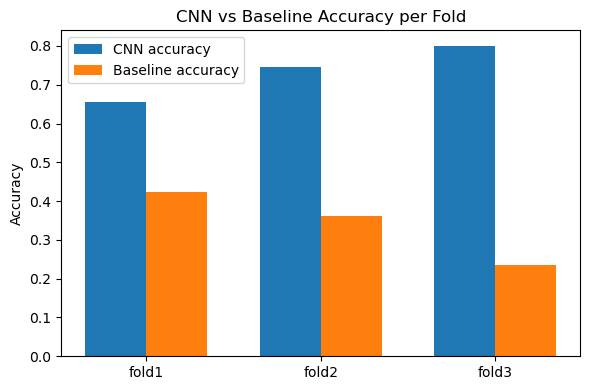

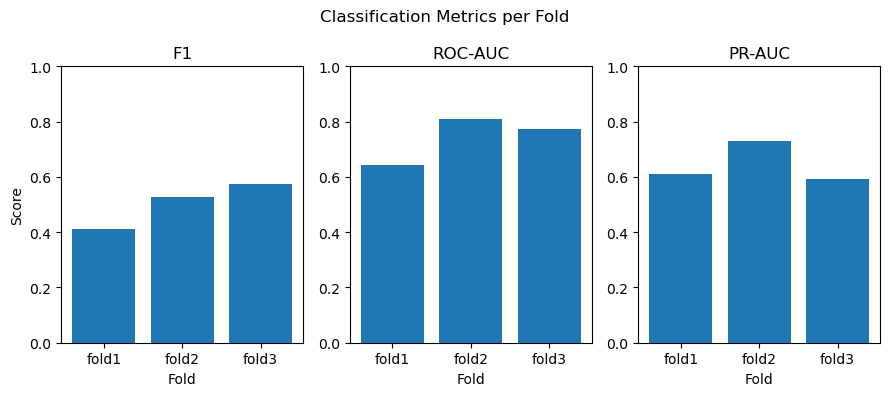

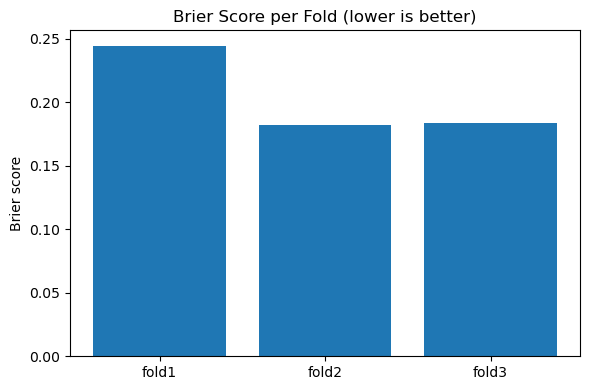

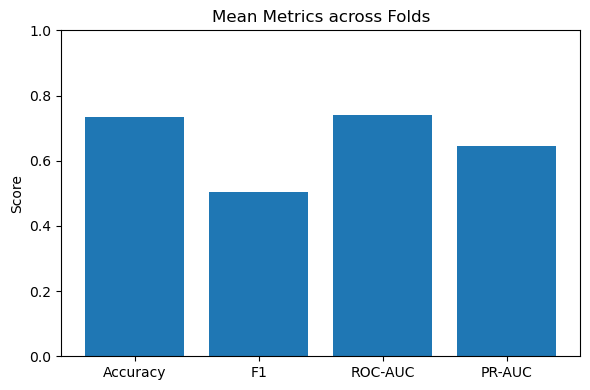

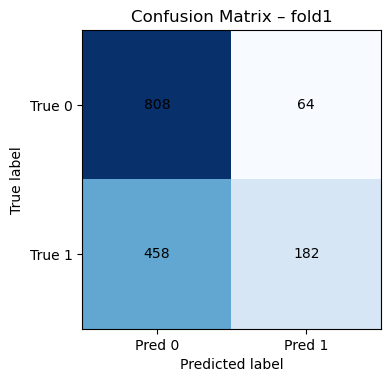

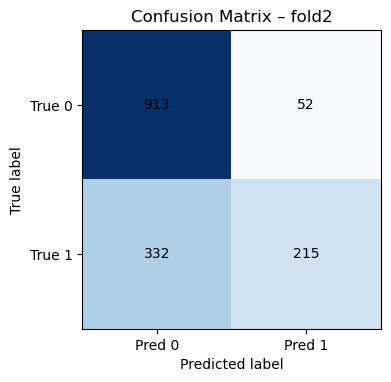

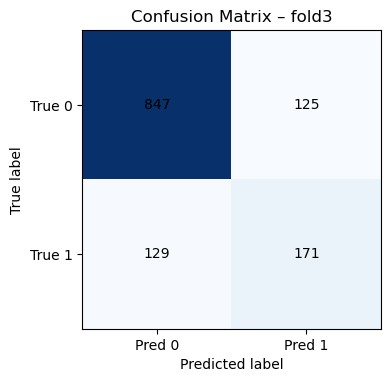

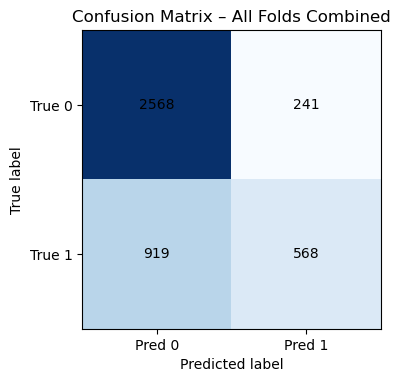

In [8]:
import numpy as np
import matplotlib.pyplot as plt

print(results_df)

folds = results_df["fold"].values
x = np.arange(len(folds))

# CNN vs Baseline Accuracy per fold
acc = results_df["accuracy"].values
baseline = results_df["baseline_acc"].values

plt.figure(figsize=(6, 4))
width = 0.35
plt.bar(x - width/2, acc, width, label="CNN accuracy")
plt.bar(x + width/2, baseline, width, label="Baseline accuracy")
plt.xticks(x, folds)
plt.ylabel("Accuracy")
plt.title("CNN vs Baseline Accuracy per Fold")
plt.legend()
plt.tight_layout()
plt.show()

# F1 / ROC-AUC / PR-AUC per fold
metrics = ["f1", "roc_auc", "pr_auc"]
metric_labels = ["F1", "ROC-AUC", "PR-AUC"]

plt.figure(figsize=(9, 4))
for i, m in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    plt.bar(folds, results_df[m].values)
    plt.ylim(0, 1)
    plt.title(metric_labels[i])
    plt.xlabel("Fold")
    if i == 0:
        plt.ylabel("Score")
plt.suptitle("Classification Metrics per Fold")
plt.tight_layout()
plt.show()

# Brier score per fold
plt.figure(figsize=(6, 4))
plt.bar(folds, results_df["brier"].values)
plt.ylabel("Brier score")
plt.title("Brier Score per Fold (lower is better)")
plt.tight_layout()
plt.show()

# Mean metrics across folds
mean_vals = {
    "Accuracy": results_df["accuracy"].mean(),
    "F1": results_df["f1"].mean(),
    "ROC-AUC": results_df["roc_auc"].mean(),
    "PR-AUC": results_df["pr_auc"].mean(),
}

plt.figure(figsize=(6, 4))
plt.bar(list(mean_vals.keys()), list(mean_vals.values()))
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Mean Metrics across Folds")
plt.tight_layout()
plt.show()

# Confusion matrices
def plot_confusion_matrix(cm, title):
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred 0", "Pred 1"])
    ax.set_yticklabels(["True 0", "True 1"])

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title)

    for i in range(2):
        for j in range(2):
            ax.text(j, i, int(cm[i, j]),
                    ha="center", va="center")

    plt.tight_layout()
    plt.show()

# Per-fold confusion matrices
for _, row in results_df.iterrows():
    tn = row["tn"]
    fp = row["fp"]
    fn = row["fn"]
    tp = row["tp"]
    cm = np.array([[tn, fp],
                   [fn, tp]])
    plot_confusion_matrix(cm, title=f"Confusion Matrix – {row['fold']}")

# Aggregated confusion matrix across folds
tn_total = results_df["tn"].sum()
fp_total = results_df["fp"].sum()
fn_total = results_df["fn"].sum()
tp_total = results_df["tp"].sum()

cm_total = np.array([[tn_total, fp_total],
                     [fn_total, tp_total]])

plot_confusion_matrix(cm_total, title="Confusion Matrix – All Folds Combined")
